Interaction Survival Analysis
===

For Ruyuan Wan's survival analysis, which requires different conditions.

Builds on the three `Extraction` jupyter notebooks in this directory.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from datetime import timezone
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support')

In [4]:
import sys
caringbridge_core_path = "/home/srivbane/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [5]:
import cbcore.data.paths as paths
import cbcore.data.dates as dates

In [6]:
working_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
assert os.path.exists(working_dir)

### Load the site metadata

In [7]:
site_metadata_filepath = "/home/lana/shared/caringbridge/data/derived/site_metadata/site_metadata.feather"
site_df = pd.read_feather(site_metadata_filepath)
len(site_df)

840943

Filter by three conditions.

In [8]:
len(site_df[site_df.visits > 2])

654980

In [9]:
len(site_df[site_df.isSpam.isna()])

748405

In [10]:
len(site_df[(site_df.isDeleted.isna())|(site_df.isDeleted == '0')])

675234

In [11]:
subset_site_df = site_df[(site_df.visits > 2)&(site_df.isSpam.isna())&((site_df.isDeleted.isna())|(site_df.isDeleted == '0'))]
len(subset_site_df)

535984

In [12]:
valid_site_ids = set(subset_site_df.site_id)
len(valid_site_ids)

535984

### Define valid time range

In [13]:
start_date = datetime.fromisoformat('2014-01-01').replace(tzinfo=timezone.utc)
start_timestamp = int(start_date.timestamp()) * 1000
end_date = datetime.fromisoformat('2019-02-19').replace(tzinfo=timezone.utc)
end_timestamp = int(end_date.timestamp()) * 1000
start_timestamp, end_timestamp

(1388534400000, 1550534400000)

### Load interactions data

In [14]:
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "interaction_metadata.feather")
merged_df =  pd.read_feather(interaction_metadata_filepath)
len(merged_df)

84822845

### Compute metrics and validate

In [15]:
# test site, that previously had omitted interactions
merged_df[merged_df.site_id == 1031356]

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial,is_self_interaction
2455068,28109834,1031356,comment,556e79fb4db92143759c188d,1433364616000,1433364616000,0,None,False
37535627,30906241,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
37535628,16828218,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
37535629,16045296,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
37535630,13834678,1031356,amps,556e79fb4db92143759c188d,1433303547000,1433303547000,0,None,False
82268213,30906954,1031356,journal,556e79fb4db92143759c188d,1433303547000,1433303547000,0,True,True


In [16]:
#compute number of amps, comments, and journals in the first 30 days on each site
days30_ms = 1000 * 60 * 60 * 24 * 30

In [17]:
df = merged_df
df.dtypes

user_id                 int64
site_id                 int64
int_type               object
journal_oid            object
created_at              int64
updated_at              int64
site_index              int64
is_nontrivial          object
is_self_interaction      bool
dtype: object

In [18]:
s = datetime.now()
df.sort_values(by=['site_id', 'created_at'], inplace=True)
print(f"{datetime.now() - s}")

0:01:43.763561


In [19]:
invalid_created_at = df.created_at <= 0
print(np.sum(invalid_created_at))
df.loc[invalid_created_at, 'created_at'] = df.loc[invalid_created_at, 'updated_at']
print(np.sum(df.created_at <= 0))

44
0


In [20]:
df.head()

,user_id,site_id,int_type,journal_oid,created_at,updated_at,site_index,is_nontrivial,is_self_interaction
66929455,1,1,journal,51bdf3e56ca0048f4e00ced4,1103856900000,1103856900000,0,True,True
66929456,1,1,journal,51bdf3e56ca0048f4e00ced2,1103943240000,1103943240000,1,True,True
66929457,1,1,journal,51bdf3e56ca0048f4e00ced0,1104288840000,1104288840000,2,True,True
66929458,1,1,journal,51bdf3e56ca0048f4e00cece,1104461640000,1104461640000,3,True,True
66929459,1,1,journal,51bdf3e56ca0048f4e00cecc,1104807180000,1104807180000,4,True,True


In [21]:
first_journal_df = df[(df.int_type=='journal')&(df.is_nontrivial == True)]
first_journal_df = first_journal_df.drop_duplicates(subset='site_id')
assert len(first_journal_df) == len(set(first_journal_df.site_id))

In [22]:
site_start_dict = {row.site_id: row.created_at 
                   for row in tqdm(first_journal_df.itertuples(), total=len(first_journal_df))}

100%|██████████| 605630/605630 [00:01<00:00, 437044.98it/s]


In [23]:
site_counts_list = []
curr_site_id = -1
site_start_timestamp = -1
skipped_site_count = 0
for row in tqdm(df.itertuples(), total=len(df)):
    site_id = row.site_id
    if site_id != curr_site_id:
        if curr_site_id != -1:
            if skip_site:
                skipped_site_count += 1
            else:
                assert max_observed_elapsed_time >= 0
                site_counts_list.append({
                    'site_id': curr_site_id,
                    'journal_count': journal_count,
                    'amps_count': amp_count,
                    'comment_count': comment_count,
                    'site_tenure': max_observed_elapsed_time
                })
        
        journal_count = 0
        amp_count = 0
        comment_count = 0
        max_observed_elapsed_time = -1
        skip_site = False
        
        curr_site_id = site_id
        if site_id not in site_start_dict:
            skip_site = True
            site_start_timestamp = 0
        else:
            site_start_timestamp = site_start_dict[site_id]
    elapsed_time = row.created_at - site_start_timestamp
    is_journal_int = row.int_type == 'journal'
    if is_journal_int and (row.created_at < start_timestamp or row.created_at > end_timestamp):
        # this site was created outside the analysis period! we only want to include sites created since 2014
        skip_site = True
    if skip_site:
        continue
    if is_journal_int and elapsed_time > max_observed_elapsed_time:
        max_observed_elapsed_time = elapsed_time
    if elapsed_time <= days30_ms:
        if is_journal_int:
            journal_count += 1
        elif not row.is_self_interaction:
            if row.int_type == 'amps':
                amp_count += 1
            elif row.int_type == 'comment':
                comment_count += 1
if not skip_site:
    site_counts_list.append({
        'site_id': curr_site_id,
        'journal_count': journal_count,
        'amps_count': amp_count,
        'comment_count': comment_count,
        'site_tenure': max_observed_elapsed_time
    })
len(site_counts_list), skipped_site_count

100%|██████████| 84822845/84822845 [03:50<00:00, 368086.69it/s]


(320063, 335123)

In [24]:
site_counts_df = pd.DataFrame(site_counts_list)
site_counts_df.head()

,site_id,journal_count,amps_count,comment_count,site_tenure
0,136505,1,0,0,0
1,140029,2,1,1,63802328000
2,153666,1,0,0,0
3,167478,1,0,0,0
4,187527,11,0,0,6460732000


In [25]:
site_counts_df[site_counts_df.site_id == 1031356]

,site_id,journal_count,amps_count,comment_count,site_tenure
139199,1031356,1,4,1,0


In [26]:
np.quantile(site_counts_df.journal_count, 0.25), np.quantile(site_counts_df.journal_count, 0.5), np.quantile(site_counts_df.journal_count, 0.75), np.quantile(site_counts_df.journal_count, 1)

(1.0, 2.0, 8.0, 1304)

In [27]:
np.quantile(site_counts_df.amps_count, 0.25), np.quantile(site_counts_df.amps_count, 0.5), np.quantile(site_counts_df.amps_count, 0.75), np.quantile(site_counts_df.amps_count, 1)

(0.0, 0.0, 12.0, 35032)

## Survival Analysis testing

In [28]:
# consider a site to be right-censored if there was a journal update within X days
right_censor_threshold_days = 90
right_censor_threshold_ms = 1000 * 60 * 60 * 24 * right_censor_threshold_days
right_censor_timestamp = end_timestamp - right_censor_threshold_ms
right_censor_timestamp

1542758400000

In [29]:
# total journals in the analysis time period
len(df[(df.int_type == 'journal')&(df.created_at >= start_timestamp)&(df.created_at<=end_timestamp)])

5017904

In [30]:
journal_df = df[(df.int_type == 'journal')&(df.site_id.isin(valid_site_ids))].copy()
len(journal_df)

16759118

In [31]:
journal_df['after_right_censor_threshold'] = journal_df.created_at >= right_censor_timestamp

In [32]:
right_censored_site_ids = set(journal_df[journal_df.after_right_censor_threshold].site_id)
len(right_censored_site_ids) / len(site_counts_df)

0.08478018390129444

In [33]:
site_counts_df['is_right_censored'] = site_counts_df.site_id.map(lambda site_id: site_id in right_censored_site_ids)
site_counts_df['is_not_right_censored'] = ~site_counts_df.is_right_censored
np.sum(site_counts_df.is_right_censored), np.sum(site_counts_df.is_right_censored) / len(site_counts_df)

(25292, 0.07902194255505947)

In [34]:
site_counts_df['interactions_count'] = site_counts_df.amps_count + site_counts_df.comment_count
site_counts_df['interactions_count_log'] = -1
site_counts_df.loc[site_counts_df.interactions_count > 0, 'interactions_count_log'] = np.log10(site_counts_df.loc[site_counts_df.interactions_count > 0, 'interactions_count'])
site_counts_df['journal_count_log'] = 0
site_counts_df.loc[site_counts_df.journal_count > 0, 'journal_count_log'] = np.log10(site_counts_df.loc[site_counts_df.journal_count > 0, 'journal_count'])

site_counts_df['has_received_interactions'] = site_counts_df.interactions_count > 0
site_counts_df['has_received_amps'] = site_counts_df.amps_count > 0
site_counts_df['has_received_comments'] = site_counts_df.comment_count > 0

site_counts_df['amps_count_log'] = 0  # these function as interactions ~ has_received_amps : amps_count_log
site_counts_df.loc[site_counts_df.amps_count > 0, 'amps_count_log'] = np.log10(site_counts_df.loc[site_counts_df.amps_count > 0, 'amps_count'])
site_counts_df['comment_count_log'] = 0
site_counts_df.loc[site_counts_df.comment_count > 0, 'comment_count_log'] = np.log10(site_counts_df.loc[site_counts_df.comment_count > 0, 'comment_count'])

site_counts_df['amps_frequency'] = site_counts_df.amps_count / site_counts_df.journal_count
site_counts_df['comment_frequency'] = site_counts_df.comment_count / site_counts_df.journal_count

site_counts_df['site_tenure_months'] = site_counts_df.site_tenure / (1000 * 60 * 60 * 24 * 30)

In [35]:
# create categorical variable from binary has_received features
interaction_category_list = []
for row in site_counts_df.itertuples():
    if row.has_received_comments and row.has_received_amps:
        intcat = 'both'
    elif row.has_received_comments:
        intcat = 'commentsonly'
    elif row.has_received_amps:
        intcat = 'ampsonly'
    else:
        intcat = 'none'
    interaction_category_list.append(intcat)
site_counts_df['interaction_category'] = interaction_category_list
site_counts_df.groupby('interaction_category').size() / len(site_counts_df)

interaction_category
ampsonly        0.006168
both            0.359195
commentsonly    0.042192
none            0.592446
dtype: float64

In [36]:
intcat_cols = pd.get_dummies(site_counts_df.interaction_category, prefix='intcat')
site_counts_df = pd.concat([site_counts_df, intcat_cols], axis=1)

In [37]:
# Should Eliminate sites with apparent tenures that are greater than the dataset space
# But this is not a problem after correcting the journal creation times as above
len(site_counts_df[site_counts_df.site_tenure <= end_timestamp - start_timestamp]) / len(site_counts_df)

1.0

In [38]:
site_counts_df.head()

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,interactions_count_log,journal_count_log,...,amps_count_log,comment_count_log,amps_frequency,comment_frequency,site_tenure_months,interaction_category,intcat_ampsonly,intcat_both,intcat_commentsonly,intcat_none
0,136505,1,0,0,0,False,True,0,-1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,none,0,0,0,1
1,140029,2,1,1,63802328000,False,True,2,0.30103,0.301030,...,0.0,0.0,0.5,0.5,24.615096,both,0,1,0,0
2,153666,1,0,0,0,False,True,0,-1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,none,0,0,0,1
3,167478,1,0,0,0,False,True,0,-1.00000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,none,0,0,0,1
4,187527,11,0,0,6460732000,False,True,0,-1.00000,1.041393,...,0.0,0.0,0.0,0.0,2.492566,none,0,0,0,1


In [39]:
s = datetime.now()
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "site_counts.csv")
site_counts_df.to_csv(interaction_metadata_filepath, index=False)
print(f"{datetime.now() - s}")
interaction_metadata_filepath

0:00:03.867708


'/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions/site_counts.csv'

### Additional inspection of data for spam

In [40]:
# a full 41% of the data have only a single journal update (so tenure = 0)
np.sum(site_counts_df.site_tenure_months == 0) / len(site_counts_df)

0.41029734770966964

In [41]:
# visual inspection of high-amps and high-comments sites suggests that they are mostly NOT spam
# rather, they are viral sites
site_counts_df[site_counts_df.amps_count > 10000].sample(n=1)

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,interactions_count_log,journal_count_log,...,amps_count_log,comment_count_log,amps_frequency,comment_frequency,site_tenure_months,interaction_category,intcat_ampsonly,intcat_both,intcat_commentsonly,intcat_none
305649,1315776,41,10409,282,3573193000,True,False,10691,4.029018,1.612784,...,4.017409,2.450249,253.878049,6.878049,1.378547,both,0,1,0,0


In [42]:
# We decided to remove sites with >100 journal updates, which are less than 0.1% of the data
np.sum(site_counts_df.journal_count >= 100), np.sum(site_counts_df.journal_count >= 100) / len(site_counts_df), np.quantile(site_counts_df.journal_count, 0.999)

(267, 0.0008342107647556887, 90.93800000002375)

In [43]:
# total number of journal updates for all sites in the sample
np.sum(site_counts_df.journal_count)

2070884

In [44]:
len(merged_df[(merged_df.site_id.isin(set(site_counts_df.site_id)))&(merged_df.int_type == 'journal')])

4151376

In [45]:
len(site_counts_df)

320063

In [46]:
320063 - 319801

262

#### Create summary histograms based on data

In [100]:
x = site_counts_df.journal_count
fig, ax = plt.subplots(1, figsize=(1,0.4), squeeze=True)

plt.hist(x[x>1], log=False, bins=np.linspace(0, 100, num=30), align='left', color='black')
#plt.xscale('log')

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_filename = "sa_poster_figures/journal_30days_hist.pdf"
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()
np.mean(x), np.std(x), np.median(x), np.sum(x <= 1) / len(x)

(6.470238671761497, 12.309561599136792, 2.0, 0.41897064015521945)

In [101]:
x = site_counts_df.amps_count
fig, ax = plt.subplots(1, figsize=(1,0.4), squeeze=True)

plt.hist(x[x>0], log=False, bins=np.linspace(0, 100, num=30), align='left', color='black')
#plt.xscale('log')

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_filename = "sa_poster_figures/amps_30days_hist.pdf"
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()
np.mean(x), np.std(x), np.median(x), np.sum(x == 0) / len(x)

(39.06288137023024, 199.53819158705033, 0.0, 0.6346375557312154)

In [102]:
x = site_counts_df.comment_count
fig, ax = plt.subplots(1, figsize=(1,0.4), squeeze=True)

plt.hist(x[x>0], log=False, bins=np.linspace(0, 100, num=30), align='left', color='black')
#plt.xscale('log')

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_filename = "sa_poster_figures/comments_30days_hist.pdf"
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()
np.mean(x), np.std(x), np.median(x), np.sum(x == 0) / len(x)

(33.84704573787036, 93.43794384869508, 0.0, 0.5986133979872712)

#### The same, but for all time, not just the first 30 days

In [87]:
# this was kind of a nightmare, but cleverly uses unstack to create 0 counts easily
# see: https://stackoverflow.com/a/49128246/4146714
subset = merged_df[merged_df.site_id.isin(set(site_counts_df.site_id))]
counts = subset.groupby(['site_id','int_type']).count().unstack(fill_value=0).stack()

In [103]:
x = counts.xs('journal', level=1).journal_oid
fig, ax = plt.subplots(1, figsize=(1,0.4), squeeze=True)

plt.hist(x[x>1], log=False, bins=np.linspace(0, 100, num=30), align='left', color='black')
#plt.xscale('log')

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_filename = "sa_poster_figures/journal_all_hist.pdf"
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()
np.mean(x), np.std(x), np.median(x), np.sum(x <= 1) / len(x)

(12.970496433514652, 33.079024057115404, 2.0, 0.40635124959773544)

In [104]:
x = counts.xs('amps', level=1).journal_oid
fig, ax = plt.subplots(1, figsize=(1,0.4), squeeze=True)

plt.hist(x[x>0], log=False, bins=np.linspace(0, 100, num=30), align='left', color='black')
#plt.xscale('log')

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_filename = "sa_poster_figures/amps_all_hist.pdf"
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()
np.mean(x), np.std(x), np.median(x), np.sum(x == 0) / len(x)

(96.77961526324505, 572.483734324595, 0.0, 0.6183126446980751)

In [105]:
x = counts.xs('comment', level=1).journal_oid
fig, ax = plt.subplots(1, figsize=(1,0.4), squeeze=True)

plt.hist(x[x>0], log=False, bins=np.linspace(0, 100, num=30), align='left', color='black')
#plt.xscale('log')

ax.set_xticks([])
ax.set_yticks([])
plt.axis('off')

plt.tight_layout(pad=0)
plt.subplots_adjust(top = 0.4, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())

bbox = matplotlib.transforms.Bbox.from_bounds(0,0,1,0.2)
image_filename = "sa_poster_figures/comments_all_hist.pdf"
plt.savefig(image_filename, format='pdf', dpi=200, pad_inches=0, bbox_inches=bbox) #, transparent=True)
plt.show()
np.mean(x), np.std(x), np.median(x), np.sum(x == 0) / len(x)

(80.60560577136376, 258.19260376652335, 0.0, 0.5873718611648332)

### Modeling dataframe

In [107]:
mdf = site_counts_df[(site_counts_df.site_tenure <= end_timestamp - start_timestamp)&(site_counts_df.journal_count<=100)]
len(mdf)

319801

In [108]:
mdf['has_received_both_interaction'] = mdf.has_received_comments * mdf.has_received_amps

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
mdf['journal_comments_interaction'] = mdf.has_received_comments * mdf.journal_count
mdf['journal_amps_interaction'] = mdf.has_received_amps * mdf.journal_count

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [110]:
mdf['journal_commentcount_interaction'] = mdf.comment_count_log * mdf.journal_count
mdf['journal_ampscount_interaction'] = mdf.amps_count_log * mdf.journal_count

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [111]:
mdf['journallog_comments_interaction'] = mdf.has_received_comments * mdf.journal_count_log
mdf['journallog_amps_interaction'] = mdf.has_received_amps * mdf.journal_count_log

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [112]:
mdf['journalcount_intcatNone_interaction'] = mdf.intcat_none * mdf.journal_count
mdf['journalcount_intcatAmpsonly_interaction'] = mdf.intcat_ampsonly * mdf.journal_count
mdf['journalcount_intcatCommentsonly_interaction'] = mdf.intcat_commentsonly * mdf.journal_count
mdf['journalcount_intcatBoth_interaction'] = mdf.intcat_both * mdf.journal_count

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [113]:
mdf['journal_frequency'] = pd.cut(mdf.journal_count, bins=[0, 2, np.max(mdf.journal_count)])
mdf = pd.concat([mdf, pd.get_dummies(mdf.journal_frequency, prefix='journal_frequency')], axis=1)

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [114]:
mdf.groupby('journal_frequency').size() / len(mdf)

journal_frequency
(0, 2]      0.525123
(2, 100]    0.474877
dtype: float64

In [115]:
mdf['journalfreq_comments_interaction'] = mdf.has_received_comments * mdf['journal_frequency_(2, 100]']
mdf['journalfreq_amps_interaction'] = mdf.has_received_amps * mdf['journal_frequency_(2, 100]']

In [116]:
mdf['journalfreq_commentcount_interaction'] = mdf.comment_count_log * mdf['journal_frequency_(2, 100]']
mdf['journalfreq_ampscount_interaction'] = mdf.amps_count_log * mdf['journal_frequency_(2, 100]']

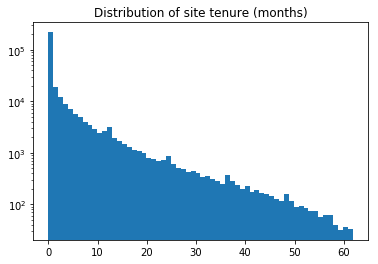

(61.80136226851852, 319801)

In [117]:
plt.hist(site_counts_df.site_tenure_months, bins=62, log=True)
plt.title("Distribution of site tenure (months)")
plt.show()
np.max(mdf.site_tenure_months), len(mdf)

In [118]:
np.sum(mdf.site_tenure_months >= 12) / len(mdf)

0.07649444498297378

In [119]:
mdf.head()

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,interactions_count_log,journal_count_log,...,journalcount_intcatAmpsonly_interaction,journalcount_intcatCommentsonly_interaction,journalcount_intcatBoth_interaction,journal_frequency,"journal_frequency_(0, 2]","journal_frequency_(2, 100]",journalfreq_comments_interaction,journalfreq_amps_interaction,journalfreq_commentcount_interaction,journalfreq_ampscount_interaction
0,136505,1,0,0,0,False,True,0,-1.00000,0.000000,...,0,0,0,"(0, 2]",1,0,0,0,0.0,0.0
1,140029,2,1,1,63802328000,False,True,2,0.30103,0.301030,...,0,0,2,"(0, 2]",1,0,0,0,0.0,0.0
2,153666,1,0,0,0,False,True,0,-1.00000,0.000000,...,0,0,0,"(0, 2]",1,0,0,0,0.0,0.0
3,167478,1,0,0,0,False,True,0,-1.00000,0.000000,...,0,0,0,"(0, 2]",1,0,0,0,0.0,0.0
4,187527,11,0,0,6460732000,False,True,0,-1.00000,1.041393,...,0,0,0,"(2, 100]",0,1,0,0,0.0,0.0


In [121]:
len(mdf)

319801

In [111]:
s = datetime.now()
user_metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions"
interaction_metadata_filepath = os.path.join(user_metadata_dir, "survival_analysis_features.csv")
mdf.to_csv(interaction_metadata_filepath, index=False)
print(f"{datetime.now() - s}")
interaction_metadata_filepath

0:00:10.539353


'/home/lana/shared/caringbridge/data/projects/sna-social-support/survival_analysis_interactions/survival_analysis_features.csv'

## Univariate Survival Analysis

Cox Regression Models

In [50]:
from lifelines import KaplanMeierFitter

In [51]:
T = mdf["site_tenure_months"]
E = ~mdf["is_right_censored"]

kmf = KaplanMeierFitter()
kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 319801 total observations, 25250 right-censored observations>

0.030598765432098766


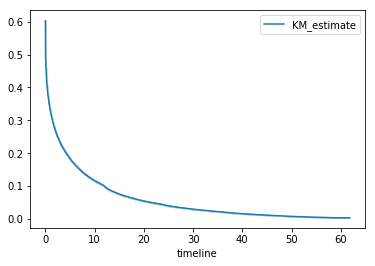

In [52]:
kmf.plot()
print(kmf.median_survival_time_)
plt.show()

100%|██████████| 50/50 [00:26<00:00,  1.91it/s]


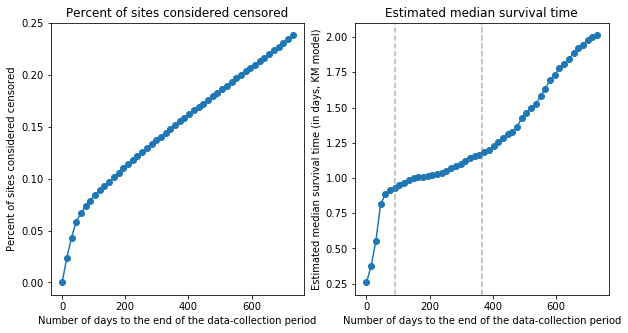

In [57]:
# investigate the choice of censorship threshold on the pct of censored data and the estimated median survival time
#censor_thresholds = [0, 30, 90, 364 / 2, 365, 500, 365*2]
censor_thresholds = np.linspace(0, 365*2, num=50)
pct_sites_considered_censored = []
median_survival_times = []
for right_censor_threshold_days in tqdm(censor_thresholds):
    right_censor_threshold_ms = 1000 * 60 * 60 * 24 * right_censor_threshold_days
    right_censor_timestamp = end_timestamp - right_censor_threshold_ms
    #print("Threshold (days):", right_censor_threshold_days)

    censored_journal_subset = journal_df[journal_df.created_at >= right_censor_timestamp]
    if len(censored_journal_subset) > 0:
        right_censored_site_ids = set(censored_journal_subset.site_id)
    else:
        right_censored_site_ids = set()

    is_right_censored = site_counts_df.site_id.map(lambda site_id: site_id in right_censored_site_ids)
    #print("pct of sites considered right-censored:", np.sum(is_right_censored) / len(site_counts_df))
    pct_sites_considered_censored.append(np.sum(is_right_censored) / len(site_counts_df))

    kmf = KaplanMeierFitter()
    kmf.fit(site_counts_df.site_tenure_months, event_observed=~is_right_censored)
    median_survival_time = kmf.median_survival_time_
    #print("KM median survival time:", median_survival_time)
    median_survival_times.append(median_survival_time)
    
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(censor_thresholds, pct_sites_considered_censored, marker='o')
axes[0].set_title("Percent of sites considered censored")
axes[0].set_xlabel("Number of days to the end of the data-collection period")
axes[0].set_ylabel("Percent of sites considered censored")

axes[1].plot(censor_thresholds, np.array(median_survival_times) * 30, marker='o')
axes[1].set_title("Estimated median survival time")
axes[1].set_xlabel("Number of days to the end of the data-collection period")
axes[1].set_ylabel("Estimated median survival time (in days, KM model)")
plt.axvline(365, color='gray', alpha=0.6, linestyle='--')
plt.axvline(90, color='gray', alpha=0.6, linestyle='--')

plt.show()

In [54]:
# empirical observed tenure is well under a month
np.median(site_counts_df.site_tenure_months)

0.008611111111111111

## Multivariate Survival Analysis

In [55]:
from lifelines import CoxPHFitter

### Most reasonable model

In [52]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'has_received_amps', 'has_received_comments', 'journal_frequency_(2, 100]', 'amps_count_log', 'comment_count_log', 'journalfreq_comments_interaction', 'journalfreq_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed
cph.print_summary()
cph.plot()
plt.show()

NameError: name 'CoxPHFitter' is not defined

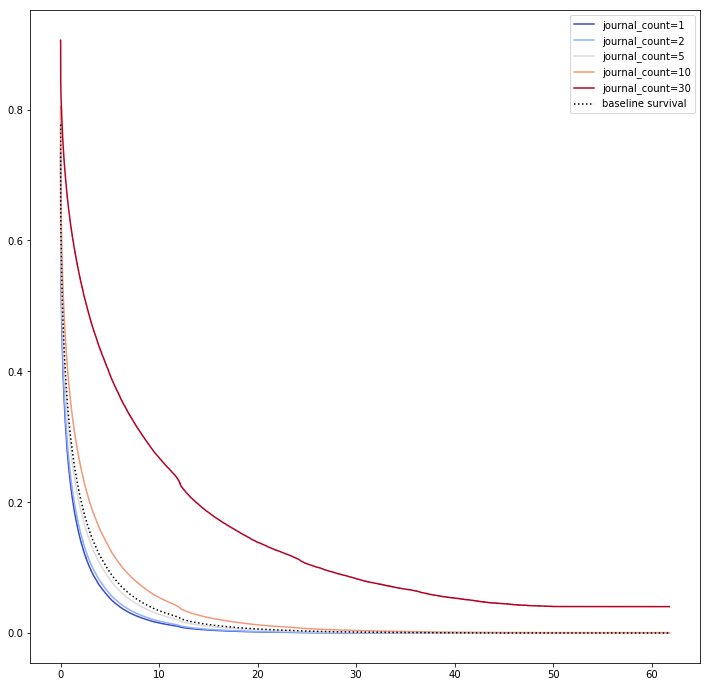

In [140]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups('journal_count', [1, 2, 5, 10, 30], cmap='coolwarm', ax=ax)
plt.show()

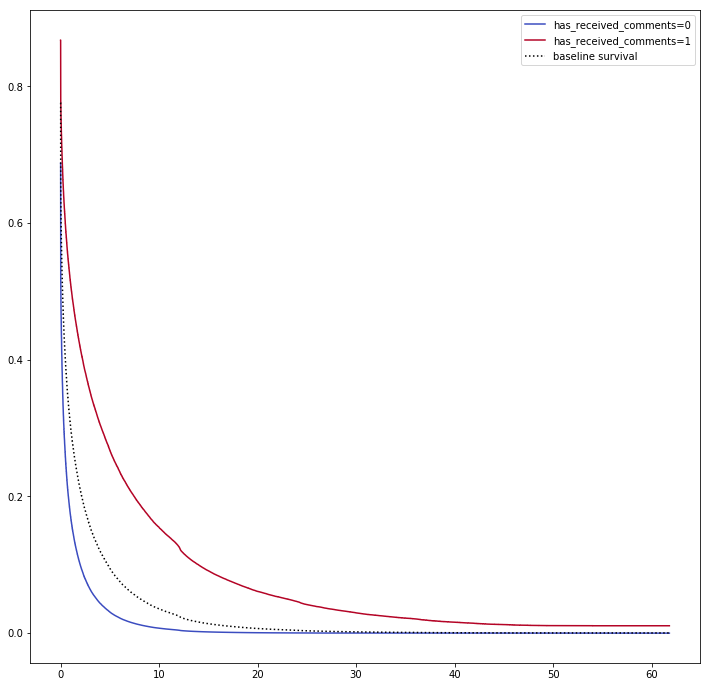

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups('has_received_comments', [0, 1], cmap='coolwarm', ax=ax)
plt.show()

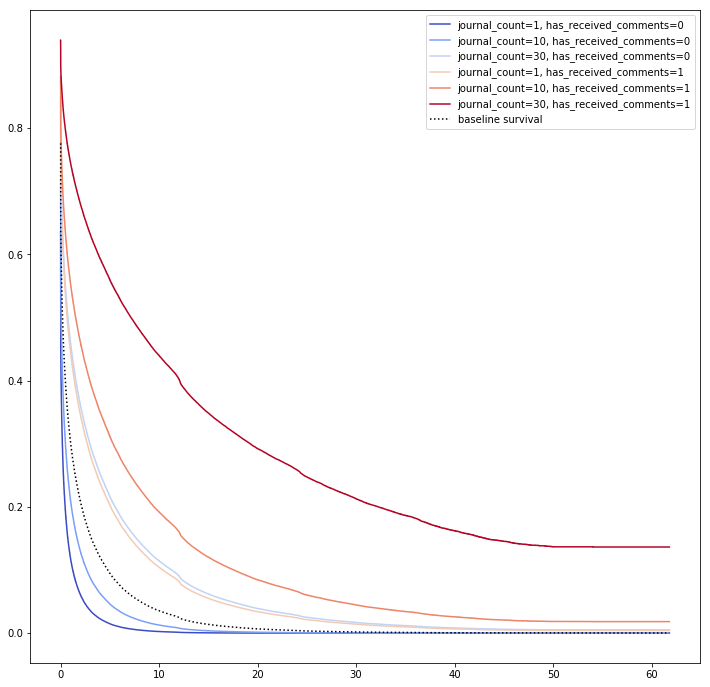

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['journal_count', 'has_received_comments'], [(1, 0), (10, 0), (30, 0), (1, 1), (10, 1), (30, 1)], cmap='coolwarm', ax=ax)
plt.show()

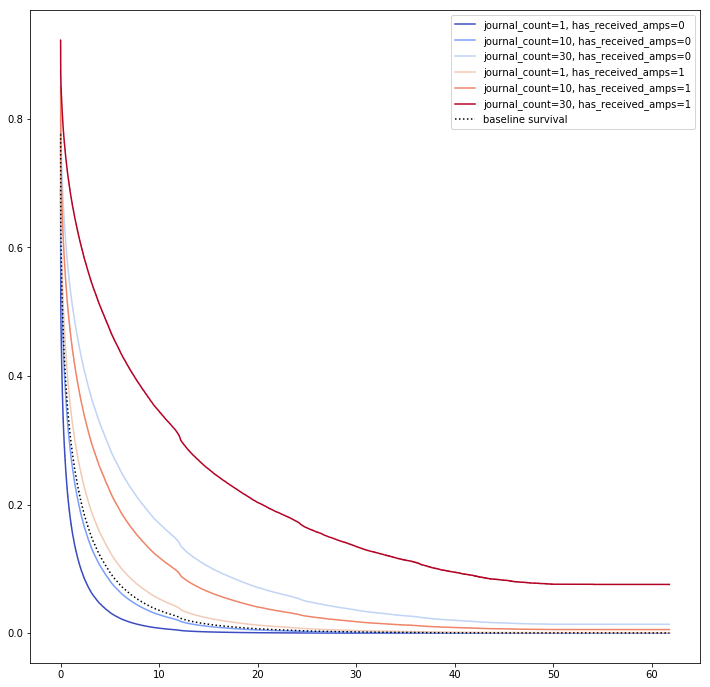

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['journal_count', 'has_received_amps'], [(1, 0), (10, 0), (30, 0), (1, 1), (10, 1), (30, 1)], cmap='coolwarm', ax=ax)
plt.show()

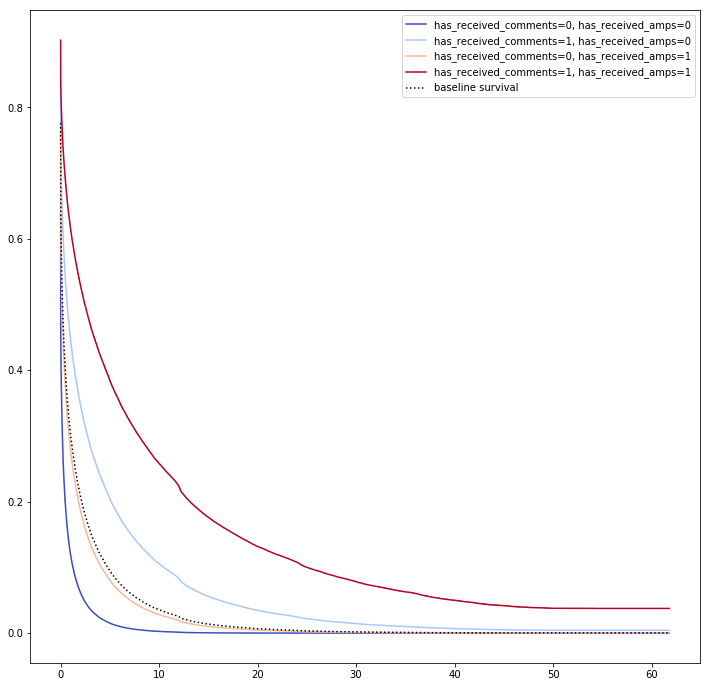

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['has_received_comments', 'has_received_amps'], [(0, 0), (1, 0), (0, 1), (1, 1)], cmap='coolwarm', ax=ax)
plt.show()

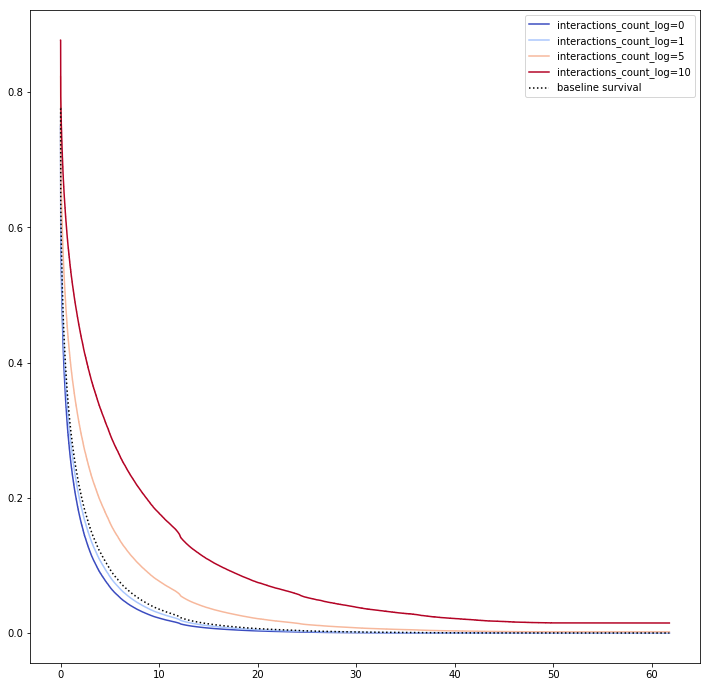

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups('interactions_count_log', [0, 1, 5, 10], cmap='coolwarm', ax=ax)
plt.show()

### Amps vs comments?

A more specific investigation into the amps vs comments question, by including the "amp_ratio" feature.

In [67]:
mdf['amp_ratio'] = 0
mdf.loc[mdf.interactions_count > 0, 'amp_ratio'] = \
    (mdf.loc[mdf.interactions_count > 0, 'amps_count'] / mdf.loc[mdf.interactions_count > 0, 'interactions_count']) - 0.5

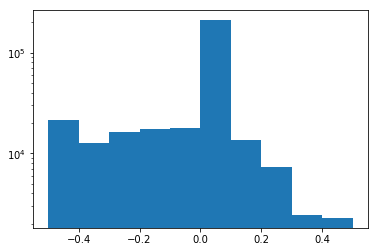

In [68]:
plt.hist(mdf.amp_ratio, log=True)
plt.show()

In [69]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'journal_count', 'interactions_count', 'amp_ratio']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 0.34761, step_size = 0.9500, ll = -3207025.78207, newton_decrement = 24291.47015, seconds_since_start = 9.5
Iteration 2: norm_delta = 0.45507, step_size = 0.9500, ll = -3174924.79077, newton_decrement = 15953.67884, seconds_since_start = 19.1
Iteration 3: norm_delta = 0.24959, step_size = 0.9500, ll = -3156195.44969, newton_decrement = 3076.51995, seconds_since_start = 28.8
Iteration 4: norm_delta = 0.09605, step_size = 0.9310, ll = -3152830.17947, newton_decrement = 240.99492, seconds_since_start = 38.2
Iteration 5: norm_delta = 0.01132, step_size = 1.0000, ll = -3152576.78739, newton_decrement = 1.82384, seconds_since_start = 47.9
Iteration 6: norm_delta = 0.00011, step_size = 1.0000, ll = -3152574.95295, newton_decrement = 0.00014, seconds_since_start = 57.5
Iteration 7: norm_delta = 0.00000, step_size = 1.0000, ll = -3152574.95281, newton_decrement = 0.00000, seconds_since_start = 67.2
Convergence success after 7 iterations.


<lifelines.CoxPHFitter: fitted with 320063 total observations, 49149 right-censored observations>

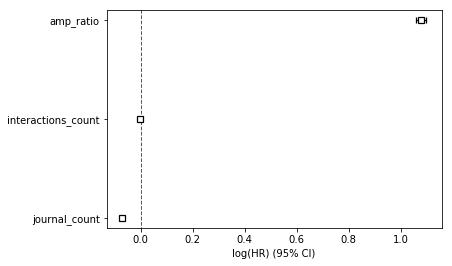

In [70]:
cph.print_summary()
cph.plot()
plt.show()

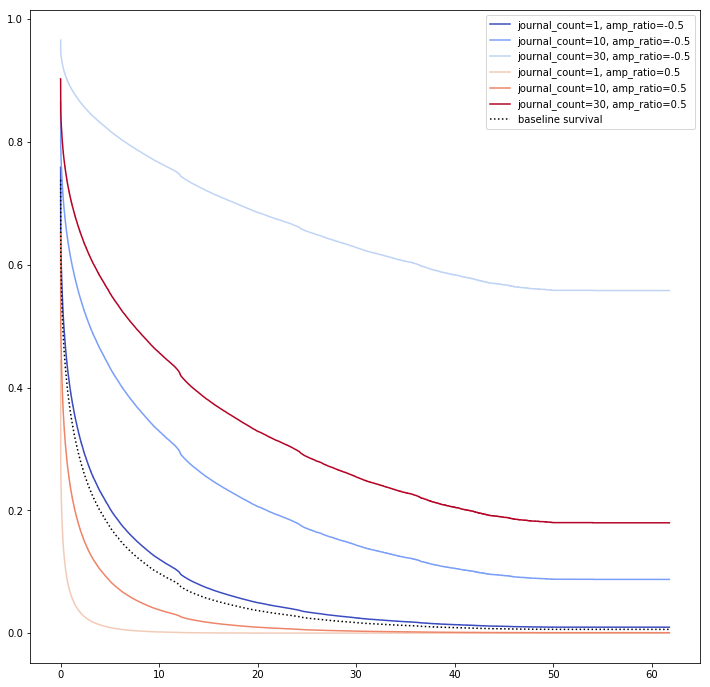

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(12,12))
cph.plot_covariate_groups(['journal_count', 'amp_ratio'], [(1, -0.5), (10, -0.5), (30, -0.5), (1, 0.5), (10, 0.5), (30, 0.5)], cmap='coolwarm', ax=ax)
plt.show()

In [145]:
np.quantile(mdf.journal_count, 0.25), np.quantile(mdf.journal_count, 0.5), np.quantile(mdf.journal_count, 0.75)

(1.0, 2.0, 8.0)

In [222]:
mdf['journal_frequency'] = pd.cut(mdf.journal_count, bins=[0, 2, 8, np.max(mdf.journal_count)])

In [165]:
mdf.journal_frequency

0           (0, 2]
1           (0, 2]
2           (0, 2]
3           (0, 2]
4         (8, 100]
            ...   
320058      (0, 2]
320059      (0, 2]
320060      (0, 2]
320061      (2, 8]
320062      (2, 8]
Name: journal_frequency, Length: 319801, dtype: category
Categories (3, interval[int64]): [(0, 2] < (2, 8] < (8, 100]]

In [152]:
# want to evaluate high vs low activity sites
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'journal_frequency', 'interactions_count_log', 'has_received_comments', 'has_received_amps']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored', strata='journal_frequency',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 0.79803, step_size = 0.9500, ll = -2927357.77534, newton_decrement = 32625.91406, seconds_since_start = 13.8
Iteration 2: norm_delta = 0.09943, step_size = 0.9500, ll = -2896268.55461, newton_decrement = 55.51902, seconds_since_start = 27.7
Iteration 3: norm_delta = 0.00476, step_size = 0.9500, ll = -2896213.26530, newton_decrement = 0.12444, seconds_since_start = 41.7
Iteration 4: norm_delta = 0.00000, step_size = 1.0000, ll = -2896213.14087, newton_decrement = 0.00000, seconds_since_start = 55.6
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 319801 total observations, 49081 right-censored observations>

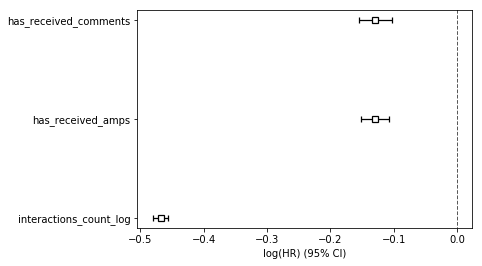

In [153]:
cph.print_summary()
cph.plot()
plt.show()

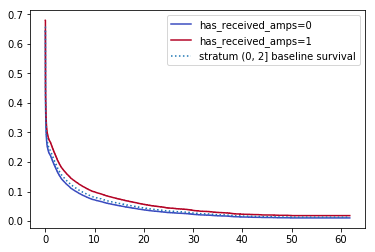

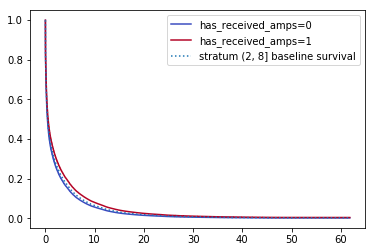

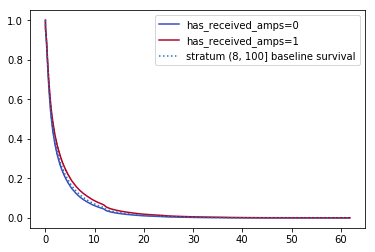

In [160]:
#fig, axes = plt.subplots(1, 3, figsize=(12,12))
cph.plot_covariate_groups('has_received_amps', [0, 1], cmap='coolwarm')
plt.show()

In [189]:
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[0],
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 12]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[0],
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 12])

(             0
 0.0   0.457560
 1.0   0.068964
 12.0  0.007185,              0
 0.0   0.719999
 1.0   0.325109
 12.0  0.125701)

In [190]:
0.325109 - 0.068964, 0.125701 - 0.007185

(0.25614499999999996, 0.11851600000000001)

In [188]:
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[2],
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 12]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency': mdf.groupby('journal_frequency').size().index[2],
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 12])

(             0
 0.0   0.999953
 1.0   0.351100
 12.0  0.003731,              0
 0.0   0.999980
 1.0   0.644178
 12.0  0.095447)

In [191]:
0.644178 - 0.351100, 0.095447 - 0.003731

(0.293078, 0.091716)

In [181]:
mdf.groupby('journal_frequency').size()

journal_frequency
(0, 2]      167935
(2, 8]       75164
(8, 100]     76702
dtype: int64

In [223]:
mdf = pd.concat([mdf, pd.get_dummies(mdf.journal_frequency, prefix='journal_frequency')], axis=1)

In [214]:
mdf.head(1)

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,has_received_interactions,has_received_amps,has_received_comments,site_tenure_months,interactions_count_log,journal_count_log,amps_count_log,comment_count_log,journal_frequency,"journal_frequency_(0, 2]","journal_frequency_(2, 8]","journal_frequency_(8, 100]"
0,136505,1,0,0,0,False,True,0,False,False,False,0.0,-1.0,0.0,0.0,0.0,"(0, 2]",1,0,0


In [215]:
# want to evaluate high vs low activity sites
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 'journal_frequency_(2, 8]', 'journal_frequency_(8, 100]', 'comment_count_log', 'amps_count_log', 'has_received_comments', 'has_received_amps']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)  # default step_size=0.95, can change to 0.5 or lower if needed

Iteration 1: norm_delta = 1.04786, step_size = 0.9500, ll = -3204498.25650, newton_decrement = 135033.12680, seconds_since_start = 9.4
Iteration 2: norm_delta = 0.24514, step_size = 0.9500, ll = -3081202.46058, newton_decrement = 2639.15622, seconds_since_start = 18.9
Iteration 3: norm_delta = 0.00666, step_size = 0.9500, ll = -3078680.03012, newton_decrement = 1.36625, seconds_since_start = 28.3
Iteration 4: norm_delta = 0.00001, step_size = 1.0000, ll = -3078678.66276, newton_decrement = 0.00000, seconds_since_start = 37.6
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3078678.66275, newton_decrement = 0.00000, seconds_since_start = 46.9
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 319801 total observations, 49081 right-censored observations>

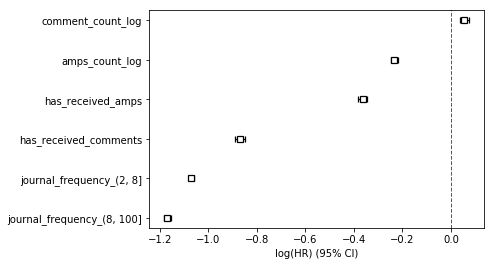

In [216]:
cph.print_summary()
cph.plot()
plt.show()

In [201]:
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 0,
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 6]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 0,
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 6])

(             0
 0.0   0.501543
 1.0   0.018166
 12.0  0.000004,              0
 0.0   0.779824
 1.0   0.235869
 12.0  0.011384)

In [203]:
0.235869 - 0.018166, 0.011384 - 0.000004

(0.21770299999999998, 0.01138)

In [202]:
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 1,
    'has_received_amps': 0,
    'has_received_comments': 0,
    'is_not_right_censored': 1,
    'interactions_count_log': -1
}), [0, 1, 6]), \
cph.predict_survival_function(pd.Series({
    'journal_frequency_(2, 8]': 0, 
    'journal_frequency_(8, 100]': 1,
    'has_received_amps': 1,
    'has_received_comments': 1,
    'is_not_right_censored': 1,
    'interactions_count_log': np.log10(2)
}), [0, 1, 6])

(            0
 0.0  0.801889
 1.0  0.277368
 6.0  0.061963,             0
 0.0  0.923516
 1.0  0.629923
 6.0  0.367033)

In [204]:
0.629923 - 0.277368, 0.367033 - 0.061963

(0.352555, 0.30507)

### Assorted models

In [54]:
mdf.columns

Index(['site_id', 'journal_count', 'amps_count', 'comment_count',
       'site_tenure', 'is_right_censored', 'is_not_right_censored',
       'interactions_count', 'interactions_count_log', 'journal_count_log',
       'has_received_interactions', 'has_received_amps',
       'has_received_comments', 'amps_count_log', 'comment_count_log',
       'amps_frequency', 'comment_frequency', 'site_tenure_months',
       'journal_comments_interaction', 'journal_amps_interaction',
       'journal_frequency', 'journal_frequency_(0, 2]',
       'journal_frequency_(2, 100]', 'journalfreq_comments_interaction',
       'journalfreq_amps_interaction', 'journalfreq_commentcount_interaction',
       'journalfreq_ampscount_interaction'],
      dtype='object')

Iteration 1: norm_delta = 1.49225, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 144712.86691, seconds_since_start = 16.5
Iteration 2: norm_delta = 0.56082, step_size = 0.9500, ll = -3341245.49967, newton_decrement = 7259.75416, seconds_since_start = 32.5
Iteration 3: norm_delta = 0.03929, step_size = 0.9500, ll = -3334558.15175, newton_decrement = 77.58772, seconds_since_start = 48.4
Iteration 4: norm_delta = 0.00104, step_size = 1.0000, ll = -3334479.66038, newton_decrement = 0.03417, seconds_since_start = 64.3
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3334479.62620, newton_decrement = 0.00000, seconds_since_start = 80.2
Convergence success after 5 iterations.


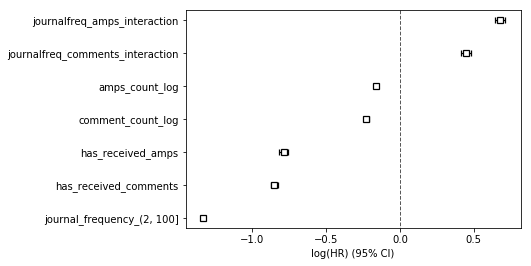

In [54]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_frequency_(2, 100]', 
             'amps_count_log', 
             'comment_count_log', 
             'journalfreq_comments_interaction', 
             'journalfreq_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 0.94580, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 135920.42427, seconds_since_start = 15.8
Iteration 2: norm_delta = 0.26906, step_size = 0.9500, ll = -3339776.21131, newton_decrement = 2839.44196, seconds_since_start = 31.7
Iteration 3: norm_delta = 0.02711, step_size = 0.9500, ll = -3337037.94119, newton_decrement = 4.65205, seconds_since_start = 47.5
Iteration 4: norm_delta = 0.00006, step_size = 1.0000, ll = -3337033.29015, newton_decrement = 0.00003, seconds_since_start = 63.4
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3337033.29012, newton_decrement = 0.00000, seconds_since_start = 79.5
Convergence success after 5 iterations.


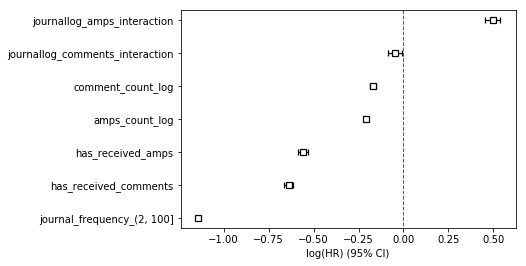

In [64]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_frequency_(2, 100]', 
             'amps_count_log', 
             'comment_count_log', 
             'journallog_comments_interaction', 
             'journallog_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 0.88043, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 134761.67306, seconds_since_start = 15.9
Iteration 2: norm_delta = 0.24879, step_size = 0.9500, ll = -3340469.64214, newton_decrement = 2746.87926, seconds_since_start = 31.9
Iteration 3: norm_delta = 0.01309, step_size = 0.9500, ll = -3337820.96893, newton_decrement = 1.92623, seconds_since_start = 47.8
Iteration 4: norm_delta = 0.00003, step_size = 1.0000, ll = -3337819.04606, newton_decrement = 0.00003, seconds_since_start = 63.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3337819.04603, newton_decrement = 0.00000, seconds_since_start = 79.8
Convergence success after 5 iterations.


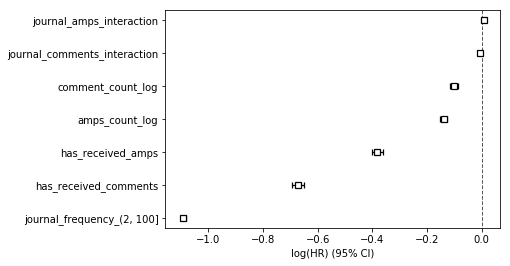

In [65]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_frequency_(2, 100]', 
             'amps_count_log', 
             'comment_count_log', 
             'journal_comments_interaction', 
             'journal_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 0.73411, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 106570.23582, seconds_since_start = 15.8
Iteration 2: norm_delta = 0.19605, step_size = 0.9500, ll = -3358121.55503, newton_decrement = 2613.13910, seconds_since_start = 31.6
Iteration 3: norm_delta = 0.04673, step_size = 0.9500, ll = -3355330.50696, newton_decrement = 116.96258, seconds_since_start = 47.5
Iteration 4: norm_delta = 0.00218, step_size = 1.0000, ll = -3355210.14067, newton_decrement = 0.24073, seconds_since_start = 63.3
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3355209.89961, newton_decrement = 0.00000, seconds_since_start = 79.1
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3355209.89961, newton_decrement = 0.00000, seconds_since_start = 94.9
Convergence success after 6 iterations.


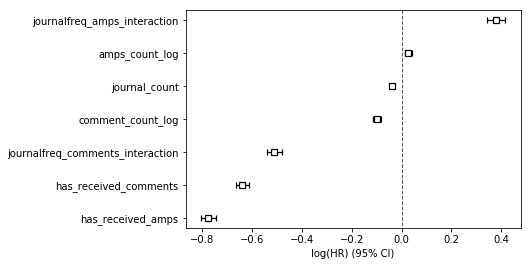

In [66]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count', 
             'amps_count_log', 
             'comment_count_log', 
             'journalfreq_comments_interaction', 
             'journalfreq_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 1.21565, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 119045.58871, seconds_since_start = 16.3
Iteration 2: norm_delta = 0.55425, step_size = 0.9500, ll = -3346116.72109, newton_decrement = 3166.51947, seconds_since_start = 32.3
Iteration 3: norm_delta = 0.23632, step_size = 0.9500, ll = -3342693.50744, newton_decrement = 250.01566, seconds_since_start = 48.3
Iteration 4: norm_delta = 0.02847, step_size = 1.0000, ll = -3342427.86318, newton_decrement = 2.62001, seconds_since_start = 64.3
Iteration 5: norm_delta = 0.00032, step_size = 1.0000, ll = -3342425.22465, newton_decrement = 0.00030, seconds_since_start = 80.2
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3342425.22435, newton_decrement = 0.00000, seconds_since_start = 96.3
Convergence success after 6 iterations.


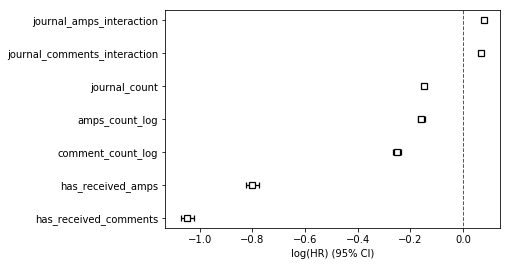

In [67]:
# this model has the clearest narrative in my opinion
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count', 
             'amps_count_log', 
             'comment_count_log', 
             'journal_comments_interaction', 
             'journal_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 1.59290, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 120287.61373, seconds_since_start = 15.8
Iteration 2: norm_delta = 0.56619, step_size = 0.9500, ll = -3345597.05803, newton_decrement = 3300.34531, seconds_since_start = 31.6
Iteration 3: norm_delta = 0.24909, step_size = 0.9500, ll = -3342049.16866, newton_decrement = 252.60347, seconds_since_start = 47.6
Iteration 4: norm_delta = 0.02874, step_size = 1.0000, ll = -3341780.79394, newton_decrement = 2.63854, seconds_since_start = 63.4
Iteration 5: norm_delta = 0.00031, step_size = 1.0000, ll = -3341778.13688, newton_decrement = 0.00030, seconds_since_start = 79.3
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3341778.13658, newton_decrement = 0.00000, seconds_since_start = 95.1
Convergence success after 6 iterations.


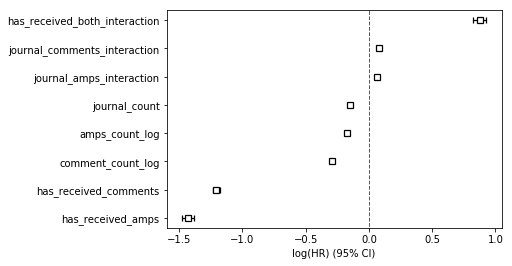

In [71]:
# this model adds has_received_both_interaction
# which models an interaction effect between receiving amps AND comments; does this matter much?
# my prior is that this effect is small; it shouldn't matter if you receive both vs only comments,
# except insofar as is already explained by total number of amps/comments.
# my prior was dumb: we should expect that receiving amps + comments is not linearly additive!
# compare this to a categorical feature with four levels: received neither, received amps, received comments, received both
# we would expect a higher coefficient on the 'received both' variable than the amps or comments variable.
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count', 
             'amps_count_log', 
             'comment_count_log', 
             'journal_comments_interaction', 
             'journal_amps_interaction',
             'has_received_both_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 1.40446, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 120287.61373, seconds_since_start = 16.3
Iteration 2: norm_delta = 0.51811, step_size = 0.9500, ll = -3345597.05803, newton_decrement = 3300.34531, seconds_since_start = 33.7
Iteration 3: norm_delta = 0.24802, step_size = 0.9500, ll = -3342049.16866, newton_decrement = 252.60347, seconds_since_start = 50.0
Iteration 4: norm_delta = 0.02874, step_size = 1.0000, ll = -3341780.79394, newton_decrement = 2.63854, seconds_since_start = 66.4
Iteration 5: norm_delta = 0.00031, step_size = 1.0000, ll = -3341778.13688, newton_decrement = 0.00030, seconds_since_start = 84.4
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3341778.13658, newton_decrement = 0.00000, seconds_since_start = 100.7
Convergence success after 6 iterations.


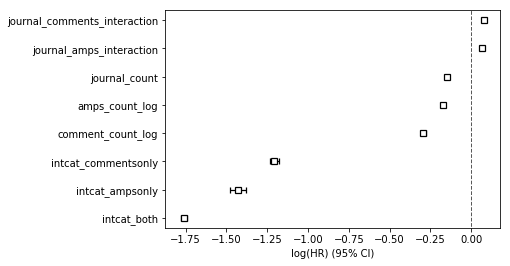

In [98]:
# main effects (categorical interaction feature) + all interactions + amp/comment count interactions
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'intcat_ampsonly', 'intcat_commentsonly', 'intcat_both', 
             'journal_count', 
             'amps_count_log', 
             'comment_count_log', 
             'journal_comments_interaction', 
             'journal_amps_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

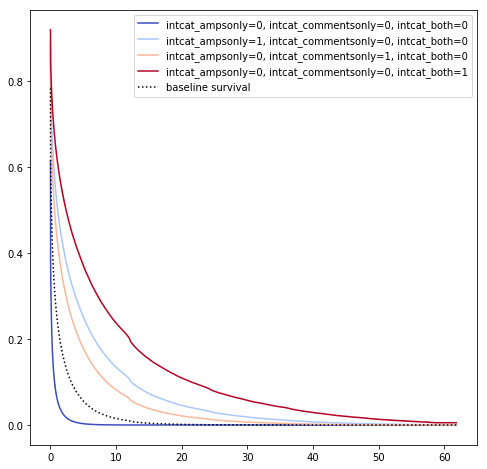

In [100]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
cph.plot_covariate_groups(['intcat_ampsonly', 'intcat_commentsonly', 'intcat_both'], 
    [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)], 
    cmap='coolwarm', ax=ax)
plt.show()

['0, 0, 0, 0, 0', '1, 0, 0, 0, 0', '1, 0, 0, 1, 0', '0, 1, 0, 0, 0', '0, 1, 0, 0, 1', '0, 0, 1, 0, 0', '1, 0, 0, 1, 1', 'baseline survival']


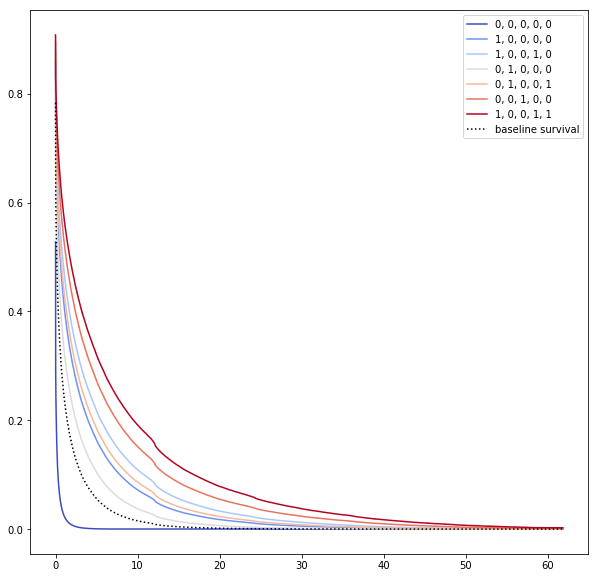

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
cph.plot_covariate_groups(['intcat_ampsonly', 'intcat_commentsonly', 'intcat_both', 'amps_count_log', 'comment_count_log'], 
    [(0, 0, 0, 0, 0), 
     (1, 0, 0, 0, 0), (1, 0, 0, np.log10(10), 0),
     (0, 1, 0, 0, 0), (0, 1, 0, 0, np.log10(10)),
     (0, 0, 1, 0, 0), (1, 0, 0, np.log10(10), np.log10(10))], 
    cmap='coolwarm', ax=ax)
handles, labels = ax.get_legend_handles_labels()
labels = [re.sub(r'[a-zA-Z_]+=', '', label) for label in labels]
ax.legend(handles, labels)
plt.show()

3 main effects (2 binary, 1 continuous):

`site_tenure_months ~ has_received_amps * has_received_comments + journal_count + has_received_amps : amps_count_log + has_received_comments : comment_count_log + has_received_amps : journal_count + has_received_comments : journal_count`

2 main effects (1 categorical, 1 continuous):

`site_tenure_months ~ factor(interaction_category) + journal_count + amps_count_log + comment_count_log + factor(interaction_category) : journal_count`

Iteration 1: norm_delta = 1.51210, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 120313.13457, seconds_since_start = 17.9
Iteration 2: norm_delta = 0.58574, step_size = 0.9500, ll = -3345605.64708, newton_decrement = 3327.81723, seconds_since_start = 35.6
Iteration 3: norm_delta = 0.25652, step_size = 0.9500, ll = -3342038.03984, newton_decrement = 254.50882, seconds_since_start = 52.8
Iteration 4: norm_delta = 0.02877, step_size = 1.0000, ll = -3341767.71218, newton_decrement = 2.64764, seconds_since_start = 69.9
Iteration 5: norm_delta = 0.00031, step_size = 1.0000, ll = -3341765.04589, newton_decrement = 0.00030, seconds_since_start = 87.7
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3341765.04559, newton_decrement = 0.00000, seconds_since_start = 105.3
Convergence success after 6 iterations.


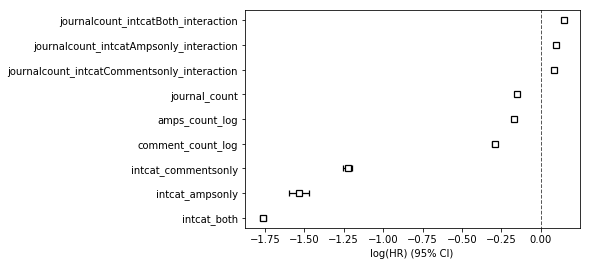

In [110]:
# journalcount_intcatBoth_interaction
# main effects (categorical interaction feature) + all interactions + amp/comment count interactions
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'intcat_ampsonly', 'intcat_commentsonly', 'intcat_both', 
             'journal_count', 
             'amps_count_log', 
             'comment_count_log', 
             'journalcount_intcatAmpsonly_interaction',
             'journalcount_intcatCommentsonly_interaction',
             'journalcount_intcatBoth_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

In [137]:
# single comment on a commentsonly site with 1 journal update
# single comment on a commentsonly site with 2 journal update
# single comment on a commentsonly site with 10 journal updates
# no comments or amps on a site with 2 journal updates
-0.15 * 1 + -1.23 + 0.08, \
-0.15 * 2 + -1.23 + 0.08 * 2, \
-0.15 * 10 + -1.23 + 0.08 * 10, \
-0.15 * 2

(-1.2999999999999998, -1.37, -1.93, -0.3)

In [136]:
-1.23 + 0.08, -1.23 + 0.08 * 10

(-1.15, -0.42999999999999994)

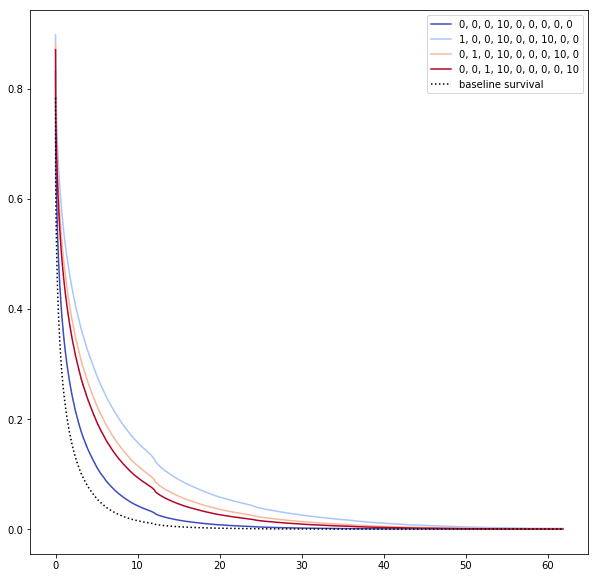

In [134]:
def get_datapoint(amp_count, comment_count, journal_count):
    intcat_ampsonly = 0
    intcat_commentsonly = 0
    intcat_both = 0
    if amp_count > 0 and comment_count > 0:
        intcat_both = 1
    elif amp_count > 0:
        intcat_ampsonly = 1
    elif comment_count > 0:
        intcat_commentsonly = 1
    amps_count_log = np.log10(amp_count) if amp_count > 0 else 0
    comment_count_log = np.log10(comment_count) if comment_count > 0 else 0
    journalcount_intcatAmpsonly_interaction = journal_count * intcat_ampsonly
    journalcount_intcatCommentsonly_interaction = journal_count * intcat_commentsonly
    journalcount_intcatBoth_interaction = journal_count * intcat_both
    return [intcat_ampsonly, intcat_commentsonly, intcat_both, journal_count, amps_count_log, comment_count_log,
            journalcount_intcatAmpsonly_interaction, journalcount_intcatCommentsonly_interaction, journalcount_intcatBoth_interaction]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
cph.plot_covariate_groups(
    ['intcat_ampsonly', 'intcat_commentsonly', 'intcat_both', 
     'journal_count', 'amps_count_log', 'comment_count_log',
     'journalcount_intcatAmpsonly_interaction', 'journalcount_intcatCommentsonly_interaction', 'journalcount_intcatBoth_interaction'], 
    [get_datapoint(0, 0, 10), 
     get_datapoint(1, 0, 10),
     get_datapoint(0, 1, 10),
     get_datapoint(1, 1, 10),
    ], 
    cmap='coolwarm', ax=ax)
handles, labels = ax.get_legend_handles_labels()
labels = [re.sub(r'[a-zA-Z_]+=', '', label) for label in labels]
ax.legend(handles, labels)
plt.show()

Iteration 1: norm_delta = 0.73163, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 105656.86960, seconds_since_start = 15.4
Iteration 2: norm_delta = 0.21079, step_size = 0.9500, ll = -3358974.14155, newton_decrement = 2735.29324, seconds_since_start = 31.6
Iteration 3: norm_delta = 0.04432, step_size = 0.9500, ll = -3356029.94467, newton_decrement = 128.83922, seconds_since_start = 47.2
Iteration 4: norm_delta = 0.00193, step_size = 1.0000, ll = -3355897.56221, newton_decrement = 0.23528, seconds_since_start = 62.7
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3355897.32665, newton_decrement = 0.00000, seconds_since_start = 78.2
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3355897.32665, newton_decrement = 0.00000, seconds_since_start = 93.7
Convergence success after 6 iterations.


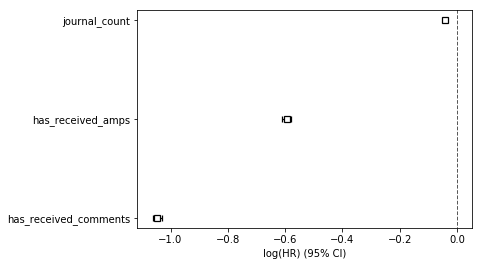

In [72]:
# main effects model
# none of the interaction features are included in this model
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 0.97703, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 106808.96201, seconds_since_start = 18.7
Iteration 2: norm_delta = 0.18283, step_size = 0.9500, ll = -3358527.55050, newton_decrement = 2860.04981, seconds_since_start = 35.3
Iteration 3: norm_delta = 0.04653, step_size = 0.9500, ll = -3355460.56326, newton_decrement = 136.76141, seconds_since_start = 51.3
Iteration 4: norm_delta = 0.00206, step_size = 1.0000, ll = -3355320.01198, newton_decrement = 0.25652, seconds_since_start = 67.4
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3355319.75514, newton_decrement = 0.00000, seconds_since_start = 83.4
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3355319.75514, newton_decrement = 0.00000, seconds_since_start = 99.5
Convergence success after 6 iterations.


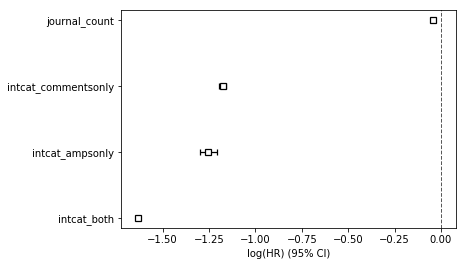

In [97]:
# main effects model w/ categorical interactions feature
# none of the interaction features are included in this model
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'intcat_ampsonly', 'intcat_commentsonly', 'intcat_both', 
             'journal_count']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 1.15361, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 115859.44566, seconds_since_start = 15.7
Iteration 2: norm_delta = 0.49298, step_size = 0.9500, ll = -3348786.64395, newton_decrement = 2433.91216, seconds_since_start = 31.8
Iteration 3: norm_delta = 0.13597, step_size = 0.9500, ll = -3346245.80751, newton_decrement = 88.33733, seconds_since_start = 47.6
Iteration 4: norm_delta = 0.00551, step_size = 1.0000, ll = -3346155.15599, newton_decrement = 0.14924, seconds_since_start = 63.3
Iteration 5: norm_delta = 0.00001, step_size = 1.0000, ll = -3346155.00658, newton_decrement = 0.00000, seconds_since_start = 79.1
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3346155.00659, newton_decrement = 0.00000, seconds_since_start = 94.9
Convergence success after 6 iterations.


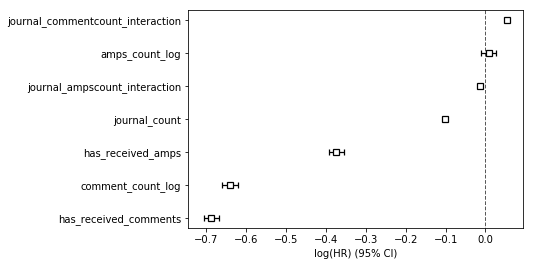

In [69]:
# experiment with journal_commentcount_interaction
# this is a weird feature, since it's an interaction of an interaction.
# not sure it's even interpretable, but...
# the idea is "does number of journals scale with number of comments in weird ways?"
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count', 
             'amps_count_log', 
             'comment_count_log', 
             'journal_commentcount_interaction', 
             'journal_ampscount_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 0.71659, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 106115.91658, seconds_since_start = 9.8
Iteration 2: norm_delta = 0.21884, step_size = 0.9500, ll = -3358416.36335, newton_decrement = 2906.82884, seconds_since_start = 19.1
Iteration 3: norm_delta = 0.04516, step_size = 0.9500, ll = -3355295.30448, newton_decrement = 134.66713, seconds_since_start = 28.7
Iteration 4: norm_delta = 0.00196, step_size = 1.0000, ll = -3355156.90429, newton_decrement = 0.25416, seconds_since_start = 38.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3355156.64980, newton_decrement = 0.00000, seconds_since_start = 47.5
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3355156.64980, newton_decrement = 0.00000, seconds_since_start = 56.9
Convergence success after 6 iterations.


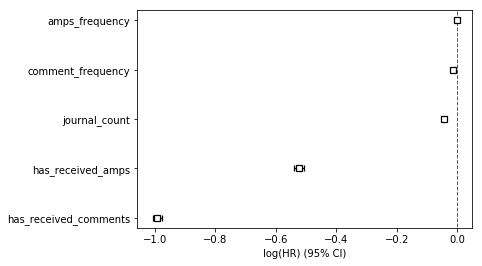

In [55]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count', 
             'amps_frequency', 'comment_frequency']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

Iteration 1: norm_delta = 0.73090, step_size = 0.9500, ll = -3460687.59178, newton_decrement = 107037.84902, seconds_since_start = 9.5
Iteration 2: norm_delta = 0.20219, step_size = 0.9500, ll = -3357539.56750, newton_decrement = 2722.36854, seconds_since_start = 19.0
Iteration 3: norm_delta = 0.04579, step_size = 0.9500, ll = -3354616.07365, newton_decrement = 127.92149, seconds_since_start = 28.6
Iteration 4: norm_delta = 0.00205, step_size = 1.0000, ll = -3354484.46739, newton_decrement = 0.25970, seconds_since_start = 38.3
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, ll = -3354484.20733, newton_decrement = 0.00000, seconds_since_start = 47.8
Iteration 6: norm_delta = 0.00000, step_size = 1.0000, ll = -3354484.20733, newton_decrement = 0.00000, seconds_since_start = 57.3
Convergence success after 6 iterations.


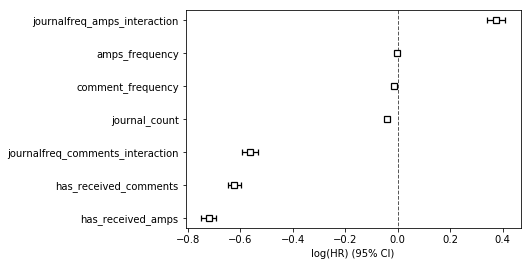

In [56]:
cph = CoxPHFitter()
cph.fit(mdf[['site_tenure_months', 'is_not_right_censored', 
             'has_received_amps', 'has_received_comments', 
             'journal_count', 
             'amps_frequency', 'comment_frequency',
             'journalfreq_amps_interaction', 'journalfreq_comments_interaction']], 
        duration_col='site_tenure_months', event_col='is_not_right_censored',
        show_progress=True)
cph.print_summary()
cph.plot()
plt.show()

### Unapologetic pre-submission scratch code

In [122]:
mdf.head()

,site_id,journal_count,amps_count,comment_count,site_tenure,is_right_censored,is_not_right_censored,interactions_count,interactions_count_log,journal_count_log,...,journalcount_intcatAmpsonly_interaction,journalcount_intcatCommentsonly_interaction,journalcount_intcatBoth_interaction,journal_frequency,"journal_frequency_(0, 2]","journal_frequency_(2, 100]",journalfreq_comments_interaction,journalfreq_amps_interaction,journalfreq_commentcount_interaction,journalfreq_ampscount_interaction
0,136505,1,0,0,0,False,True,0,-1.00000,0.000000,...,0,0,0,"(0, 2]",1,0,0,0,0.0,0.0
1,140029,2,1,1,63802328000,False,True,2,0.30103,0.301030,...,0,0,2,"(0, 2]",1,0,0,0,0.0,0.0
2,153666,1,0,0,0,False,True,0,-1.00000,0.000000,...,0,0,0,"(0, 2]",1,0,0,0,0.0,0.0
3,167478,1,0,0,0,False,True,0,-1.00000,0.000000,...,0,0,0,"(0, 2]",1,0,0,0,0.0,0.0
4,187527,11,0,0,6460732000,False,True,0,-1.00000,1.041393,...,0,0,0,"(2, 100]",0,1,0,0,0.0,0.0


In [138]:
np.quantile(mdf.amps_count, 0.95), np.quantile(mdf.amps_count, 0.85), np.quantile(mdf.amps_count, 0.75)

(185.0, 45.0, 12.0)

In [137]:
np.quantile(mdf.comment_count, 0.95), np.quantile(mdf.comment_count, 0.85), np.quantile(mdf.comment_count, 0.75)

(177.0, 66.0, 27.0)

In [139]:
np.quantile(mdf.journal_count, 0.95), np.quantile(mdf.journal_count, 0.85), np.quantile(mdf.journal_count, 0.75)

(24.0, 13.0, 8.0)